<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders on Tabular Data

* Normalizaing data: https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
* Keras functional API for more flexible models: https://keras.io/getting-started/functional-api-guide/
* Batch Size should not matter too much, but larger batch sizes might require more training epochs: https://ieeexplore.ieee.org/document/8323035

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


## Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   523k      0 --:--:-- --:--:-- --:--:--  523k


In [0]:
import pandas as pd

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [5]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


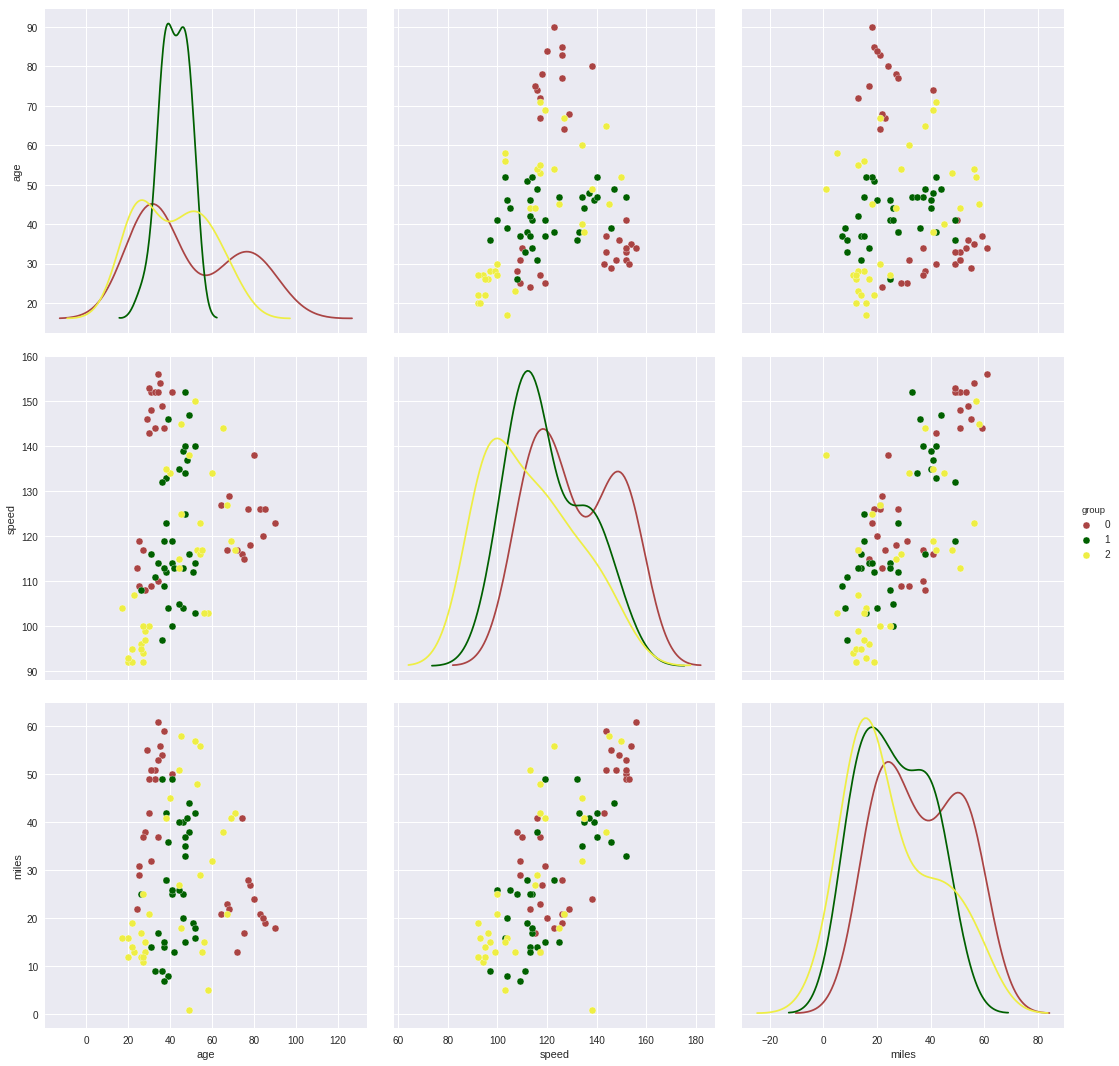

In [6]:
import seaborn as sns

sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, 
             hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'},
#              kind='reg',
             size=5,
             diag_kind='kde',
             vars=['age', 'speed', 'miles'])

## The embedding network

### Network Architecture

In [7]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model

encoding_dim = 32

# https://keras.io/getting-started/functional-api-guide/
input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
encoder (Dense)              (None, 32)                160       
_________________________________________________________________
decoder (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


### Training

In [8]:
X = df
BATCH_SIZE = 1 # larger batch size might force more epochs
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 89.6819
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.6331
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1449
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0546
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0201
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0117
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0431
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0082
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0259
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0232
CPU times: user 1min 4s, sys: 9.02 s, total: 1min 13s
Wall time: 52.6 s


### Evaluation

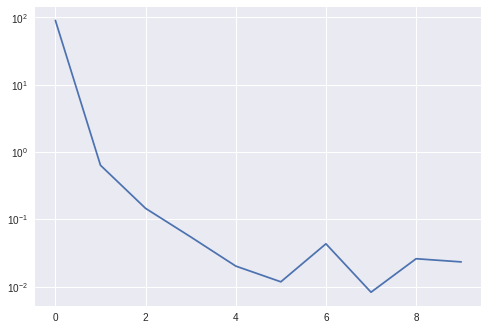

In [9]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.plot(history.history['loss'])

In [10]:
loss = autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)
loss

1500/1500 [==============================] - 2s 1ms/step


0.00010838500690078944

In [11]:
samples = df.sample(10).reset_index(drop=True)
samples

,speed,age,miles,group
0,105.0,28.0,14.0,2
1,137.0,50.0,50.0,1
2,152.0,41.0,50.0,0
3,98.0,28.0,19.0,2
4,106.0,41.0,10.0,1
5,104.0,66.0,25.0,1
6,119.0,71.0,7.0,0
7,95.0,28.0,12.0,2
8,111.0,52.0,23.0,0
9,100.0,45.0,29.0,1


In [12]:
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,105.006355,28.005102,13.994479,2.011775
1,137.010941,50.003819,50.003281,1.006721
2,152.010803,41.010361,49.999668,0.004367
3,98.007423,28.007994,18.992090,2.016322
4,106.008636,41.001251,9.997078,1.012202
5,104.012230,65.993263,25.005018,1.013815
6,119.011353,70.986557,7.009603,0.005133
7,95.006943,28.006269,11.992258,2.015953
8,111.012154,52.003250,22.997618,0.015320
9,100.011345,45.006397,28.994770,1.019334


In [13]:
samples.subtract(predictions)

,speed,age,miles,group
0,-0.006355,-0.005102,0.005521,-0.011775
1,-0.010941,-0.003819,-0.003281,-0.006721
2,-0.010803,-0.010361,0.000332,-0.004367
3,-0.007423,-0.007994,0.007910,-0.016322
4,-0.008636,-0.001251,0.002922,-0.012202
5,-0.012230,0.006737,-0.005018,-0.013815
6,-0.011353,0.013443,-0.009603,-0.005133
7,-0.006943,-0.006269,0.007742,-0.015953
8,-0.012154,-0.003250,0.002382,-0.015320
9,-0.011345,-0.006397,0.005230,-0.019334


## Looks quite nice, but how impressed are you by abstracting 4 variables into 32 / Let us try dimension of 2

Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 3092.5922
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 1265.6639
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 506.2292
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 254.1150
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 211.7804
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 209.3767
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 209.2623
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 209.3607
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 209.3151
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 209.2853
CPU times: user 1min 4s, sys: 8.57 s, total: 1min 13s
Wall time: 52.3 s


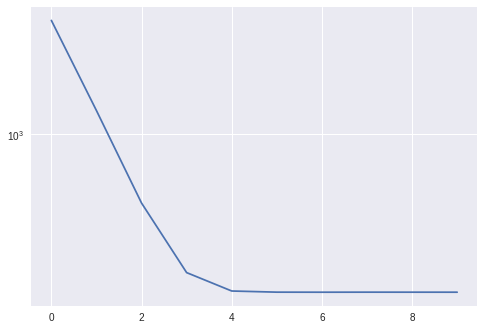

In [14]:
from tensorflow.keras.initializers import glorot_normal

encoding_dim = 2
seed = 13 # make training results more deterministic

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='tanh', name="encoder", kernel_initializer=glorot_normal(seed=seed))(input_data)
decoded = Dense(units=4, activation='linear', name="decoder", kernel_initializer=glorot_normal(seed=seed))(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# this does not get much better than 210 as a loss (bad), so we can just as well get there a bit faster (10 instead of 50 epochs with standard lr)
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')

X = df
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, verbose=1)

plt.yscale('log')
plt.plot(history.history['loss'])

In [15]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 2s 2ms/step


209.07950509087246

In [16]:
# just average over all of them :D
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,122.324783,44.505058,30.491434,0.977532
1,122.324783,44.505058,30.491434,0.977532
2,122.324783,44.505058,30.491434,0.977532
3,122.324783,44.505058,30.491434,0.977532
4,122.324783,44.505058,30.491434,0.977532
5,122.324783,44.505058,30.491434,0.977532
6,122.324783,44.505058,30.491434,0.977532
7,122.324783,44.505058,30.491434,0.977532
8,122.324783,44.505058,30.491434,0.977532
9,122.324783,44.505058,30.491434,0.977532


In [17]:
samples.describe()

,speed,age,miles,group
count,10.0000,10.000000,10.000000,10.000000
mean,112.7000,45.000000,23.900000,1.000000
std,18.4032,15.238839,15.394443,0.816497
min,95.0000,28.000000,7.000000,0.000000
25%,101.0000,31.250000,12.500000,0.250000
50%,105.5000,43.000000,21.000000,1.000000
75%,117.0000,51.500000,28.000000,1.750000
max,152.0000,71.000000,50.000000,2.000000


### relu makes it train

Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 961.1062
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 61.7937
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 38.4376
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 37.1393
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.6535
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.3808
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.2940
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.3119
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.0588
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 36.0816
CPU times: user 1min 4s, sys: 8.8 s, total: 1min 13s
Wall time: 52.4 s


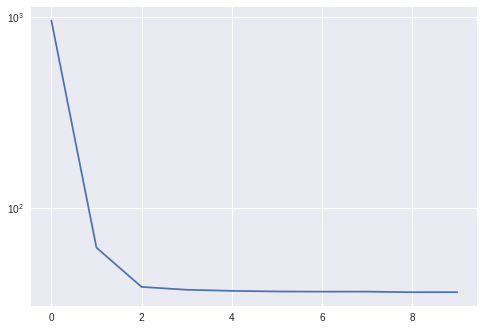

In [18]:
from tensorflow.keras.initializers import glorot_normal

encoding_dim = 2
seed = 13 # if it trains still depens on initialization

input_data = Input(shape=(4,))
# notice relu
encoded = Dense(units=encoding_dim, activation='relu', name="encoder", kernel_initializer=glorot_normal(seed=seed))(input_data)
decoded = Dense(units=4, activation='linear', name="decoder", kernel_initializer=glorot_normal(seed=seed))(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')

X = df
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, verbose=1)

plt.yscale('log')
plt.plot(history.history['loss'])

In [19]:
samples

,speed,age,miles,group
0,105.0,28.0,14.0,2
1,137.0,50.0,50.0,1
2,152.0,41.0,50.0,0
3,98.0,28.0,19.0,2
4,106.0,41.0,10.0,1
5,104.0,66.0,25.0,1
6,119.0,71.0,7.0,0
7,95.0,28.0,12.0,2
8,111.0,52.0,23.0,0
9,100.0,45.0,29.0,1


### not too bad, but all groups close to 1, all off as do not add much to loss


In [20]:
predictions = pd.DataFrame(autoencoder.predict(samples), columns=["speed",	"age",	"miles",	"group"])
predictions

,speed,age,miles,group
0,100.597038,31.798237,25.741081,0.795239
1,142.018555,45.768867,36.618427,0.902803
2,154.368027,38.997215,43.488327,0.936363
3,95.980522,29.856318,24.656406,0.783303
4,101.589111,44.810013,21.797567,0.796087
5,106.914291,63.625210,17.552052,0.807595
6,115.118599,74.234894,17.105749,0.827831
7,91.192757,31.357683,22.365736,0.770446
8,111.122581,52.036415,22.970951,0.820297
9,102.549118,43.043285,22.742928,0.798865


In [21]:
samples.subtract(predictions)

,speed,age,miles,group
0,4.402962,-3.798237,-11.741081,1.204761
1,-5.018555,4.231133,13.381573,0.097197
2,-2.368027,2.002785,6.511673,-0.936363
3,2.019478,-1.856318,-5.656406,1.216697
4,4.410889,-3.810013,-11.797567,0.203913
5,-2.914291,2.374790,7.447948,0.192405
6,3.881401,-3.234894,-10.105749,-0.827831
7,3.807243,-3.357683,-10.365736,1.229554
8,-0.122581,-0.036415,0.029049,-0.820297
9,-2.549118,1.956715,6.257072,0.201135


### Let's try normalizing the data first (caution: losses do not compare any more)

In [28]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
normalized_df = (df - df.mean()) / df.std()
normalized_df.head()

,speed,age,miles,group
0,-1.391286,-0.057247,-0.356309,0.001632
1,-0.255202,0.526510,-0.421879,0.001632
2,-0.652832,-1.108011,0.233824,-1.222706
3,-1.448090,-1.166386,-1.339863,1.225971
4,-0.482419,-0.407502,-0.553020,0.001632


Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.6657
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3895
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3520
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3430
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3391
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3377
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3364
Epoch 8/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3356
Epoch 9/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3347
Epoch 10/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3336
CPU times: user 1min 3s, sys: 8.42 s, total: 1min 12s
Wall time: 51.8 s


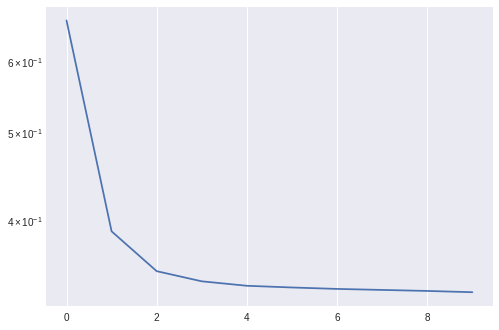

In [29]:
X = normalized_df

encoding_dim = 2
seed = 13 # make results determinisitic

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder", kernel_initializer=glorot_normal(seed=seed))(input_data)
decoded = Dense(units=4, activation='linear', name="decoder", kernel_initializer=glorot_normal(seed=seed))(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')

BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, verbose=1)

plt.yscale('log')
plt.plot(history.history['loss'])

## This makes it very hard to estimate how well we did our job, but we can still plot the embedding

Could be interpreted as a fancy version of dimensionality reduction


In [0]:
encoder = Model(inputs=input_data, outputs=encoded)
latent_representation = encoder.predict(X)

In [25]:
latent_representation.shape

(1500, 2)

### Look, ma, clusters

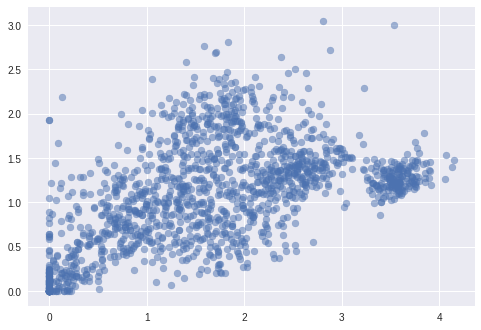

In [26]:
latent_x = latent_representation[:, 0]
latent_y = latent_representation[:, 1]
plt.scatter(latent_x, latent_y, alpha=0.5)

### Clusters have actual meaning

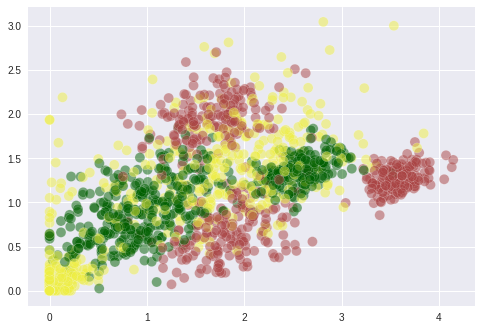

In [27]:
from matplotlib.colors import ListedColormap

# * 0 - red: many accidents
# * 1 - green: few or no accidents
# * 2 - yellow: in the middle
colors = X['group']
color_map = ListedColormap(['#AA4444', '#006000', '#EEEE44'])

plt.scatter(latent_x, latent_y, alpha=0.5, s=100, marker='o', edgecolors='w', cmap=color_map, c=colors)